# Figure 10: colour plots for the invasion probability and expected time over all possible initial state conditions for the 30 mosquito model with no reversion

## Abby Barlow, University of Bath
## Ben Adams, University of Bath

Import required libraries

In [15]:
import numpy as np
import pylab as plt
import matplotlib
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle

Import required scripts

In [10]:
import importlib
import Rate_transitions
import Finding_dictionary_keys
import Prob_absorb_to_each
import Time_absorb_wild_states
import Hughes_model

get_transition = Rate_transitions.get_transition_Hughes
find_keys = Finding_dictionary_keys.find_keys
prob_reach_absorb = Prob_absorb_to_each.prob_reach_absorb_Hughes
F = Hughes_model.F_hughes
absorb_time_wolb = Time_absorb_wild_states.absorb_time_wolb_Hughes

# scripts autosave, so no need to re-run code chunk after making changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Parameter values

In [4]:
K = 30        # reproductive carrying capacity
d1 = 12/100   # wild-type death rate
d2 = 12/100   # Wolbachia death rate
phi = 9/10    # Wolbachia fitness

v = 10/10     # probability of vertical transmission
u = 10/10     # ratio of unviable offspring produced by an infected male and uninfected female

k = 0.3           # Mosquito competition parameter
h = 0.19*100**k   # Mosquito competition parameter

b1 = round(d1/F(10,h,k),2) # wild-type per capita birth rate
b2 = b1*phi                # Wolbachia per capita birth rate

# create a dictionary to store all parameter values
params_dict = {'b1': b1,
              'b2': b2,
              'K': K,
              'd1': d1,
              'd2': d2,
              'v': v,
              'phi': phi,
              'u': u,
              'h': h,
              'k': k
              }

Construct dictionaries for the full state space and the transient state space (mixed states)

In [5]:
max_pop = 30  # maximum household size
state_dict = {index: np.array((i, j)) for index, (i, j) in enumerate([(i, j) for i in range(max_pop + 1) for j in range(max_pop + 1) if i + j <= max_pop])}
trans_dict = {index: np.array((i,j)) for index, (i,j) in enumerate([(i, j) for i in range(1,max_pop + 1) for j in range(1,max_pop + 1) if i + j <= max_pop])}

Calculating the probability of reaching the wolbachia-only state space from each initial condition state

In [6]:
n_transient = len(trans_dict)            # number of transient states i.e. mixed
prob_reach_wolb = np.zeros(n_transient)  # initialise an array to hold all the probabilities for the mixed states
for i in range(max_pop):                 # looping over the Wolbachia-only state space
    absorb_state = np.array([0,i+1])     # current Wolbachia-only state (absorbing state)
    # adding the probability of reaching that state from each initial mixed state to the probabilities array
    prob_reach_wolb[:] += np.transpose(prob_reach_absorb(state_dict,trans_dict,absorb_state,params_dict)[0])[0]

Putting the probabilities into an array in the correct format for the colour plot and adding the trivial probabilities of invasion from the wild-type-only and Wolbachia-only states

In [7]:
col_map = np.zeros((max_pop+1,max_pop+1))  # initialing array for all the probabilities

for i in range(max_pop):   # looping over the wild-type/ Wolbachia-only state space
    col_map[i+1,0] = 0     # probability of invasion starting from a wild-type only state is 0
    col_map[0,i+1] = 1     # probability of invasion starting from a Wolbachia only state is 1
    
for k in range(n_transient):         # looping over all the mixed/ transient states
    # setting the index of the current invasion probability corresponding to the intial state
    indx1, indx2 = trans_dict[k]
    col_map[indx1,indx2] = prob_reach_wolb[k]  # recording the probability

Plotting the figure

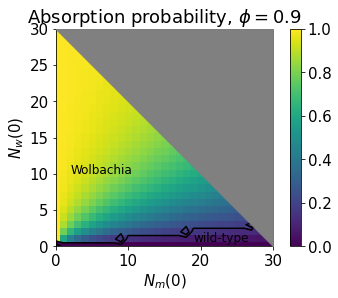

In [9]:
fig, ax = plt.subplots()  # define subsplots, as overlaying mean-field results
matplotlib.rcParams.update({'font.size': 15})  # font size

Z = np.transpose(col_map)   # swaps to correct way round 
my_cmap = plt.cm.viridis    # colour scheme
num_levels = 1000000
my_cmap = ListedColormap(my_cmap(np.linspace(0, 1, num_levels)))   # define how fine a colour scale want
color_plot = ax.imshow(Z, cmap = my_cmap, interpolation ='nearest', origin = 'lower')  # produces colour plot
ax.set_xlabel('$N_m(0)$')   # x label
ax.set_ylabel('$N_w(0)$')   # y label

x = np.arange(Z.shape[1])   # extracts the x values
# fills the top right half grey, this part of the state space is out of bounds
plt.fill_between(x,30-x,30,color='gray',zorder=10) # zorder command ensures brought to the front
contours = np.load('contours_phi09_dye.npy')       # import corrsponding mean-field results 
levels = np.linspace(np.min(contours), np.max(contours), num=5) # produces the contours from the mean-field result
# num controls the number of contours shown
contour_plot = ax.contour(contours, levels=levels, colors='black')  # plotd the contours

ax.set_xlim(0,30)   # x limit
ax.set_ylim(0,30)   # y limit

# labels SS attraction under mean-field model
plt.text(2,10,'Wolbachia',fontsize=12)
plt.text(19,0.7,'wild-type',fontsize=12)

color_bar = fig.colorbar(color_plot)   # adds colour bar
ax.set_title('Absorption probability, $\phi=${}'.format(phi))    # title

plt.savefig('bifurcation_color_map_v1.pdf', bbox_inches='tight')  # saves figure

To reproduce Figure 11 see comments at the end of the 'Figure_3.ipynb' notebook and rerun the above code for $\phi=0.7$.

Finding the expected time until the Wolbachia-only state space is reached with respect to each possible mixed state.

In [11]:
invade_time = absorb_time_wolb(max_pop,np.ones(n_transient),params_dict) # fincing the escpected invasion times

Putting the expected times into an array in the correct format for the colour plot and adding the trivial invasion times from the wild-type-only and Wolbachia-only states.

In [13]:
col_map_time = np.zeros((max_pop+1,max_pop+1))  # initialing array for all the invasion times
    
for k in range(n_transient):    # looping over all the mixed/ transient states                  
    # setting the index of the current invasion probability corresponding to the intial state
    indx1, indx2 = trans_dict[k]
    col_map_time[indx1,indx2] = invade_time[k]  # recording the expcted invasion time
    
for i in range(max_pop):  # looping over the wild-type/ Wolbachia-only state space
    # invasion time starting from a wild-type only state is infinite 
    # (we just use a place holder here and colout accordingly in the figure)
    col_map_time[i+1,0] = 0     
    col_map_time[0,i+1] = 0  # expected invasion time from a Wolbachia-only state is 0

Plotting the figure

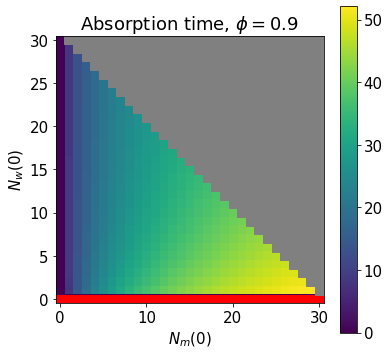

In [18]:
matplotlib.rcParams.update({'font.size': 15})   # font size 
plt.figure(figsize=(6, 6))                      # figure size

Z = np.transpose(col_map_time)    # change to right way round
my_cmap = plt.cm.viridis          # colour scheme
num_levels = 100000
my_cmap = ListedColormap(my_cmap(np.linspace(0, 1, num_levels)))   # define how fine a colour scale want
plt.imshow(Z, cmap=my_cmap, interpolation='nearest', origin='lower')  # produces colour plot
plt.xlabel('$N_m(0)$')  # x label
plt.ylabel('$N_w(0)$')  # y label

# highlights the specific squares with a red rectangle
# this is to denote the initial states over which the expected time to invasion is infinite
highlight_row, highlight_col = 0, 0
rect = Rectangle((highlight_col - 0.5, highlight_row - 0.5), 31, 1, facecolor='red')
current_axes = plt.gca()          # saves current axes
current_axes.add_patch(rect)      # adds rectangle

# colours the squares corresponding to the state space that is out of bounds grey
for i in range(max_pop):   # looping over the y axis
    highlight_row, highlight_col = max_pop-i,1+i
    rect = Rectangle((highlight_col - 0.5, highlight_row - 0.5), max_pop, 1, edgecolor='gray', facecolor='gray')
    current_axes.add_patch(rect)    # adds the rectangle

plt.colorbar()    # adds colour bar
plt.title('Absorption time, $\phi=${}'.format(phi))        # title
plt.savefig('absorb_time_color_map_v1.pdf', bbox_inches='tight')   # save figure